## Explicit Solutions

This notebook will show how to fit explicit solutions to summary measures.

It will first fit the Rescorla-Wagner model to the trial-by-trial response rates. It will then fit Modular Theory to the same trial-by-trial response rates. While the Rescorla-Wagner model is restricted to fitting response rate data (or some transform of it), Modular Theory can fit both response rate and response timing data. So the last section fits Modular Theory to the averaged response gradient.

## 1.0 Setting up the code environment

### 1.1 Importing packages

In [1]:
# System packages
import sys

# Storing and manipulating data...
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit, minimize
from scipy.stats import norm, pearsonr

# Plotting...
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# The following packages are unique to this script
from create_data_file import create_modular_theory_file

### 1.2 Processing the data

The data is stored as text files. They first need to be loaded and processed. The following command does this, and returns a single (processed) csv file that is saved to your computer. It only creates the file if one doesn't already exist.

In [2]:
create_modular_theory_file(how="acquisition") # only process the acquisition data

Creating file...done (already present)


### 1.3 Loading the data into a pandas DataFrame

In [3]:
full_data = pd.read_csv("../data/modular_theory2007/Data_Modular_Theory2007.csv", engine="c")

For this analysis, we only need a portion of the data. We'll take the FI-120 acquisition data.

In [4]:
interval = 120
trialname = "FI{}".format(interval)
row_idx = (full_data["trial_"+trialname] > 0) & (full_data.phase == "acquisition")
col_idx = ["subject", "session", "trial_"+trialname, "time_"+trialname, "event"]

data = full_data.ix[row_idx, col_idx]

data = data.rename(columns={"trial_"+trialname:"trial",
                            "time_"+trialname:"time"})

## 2.0 Analysis of the learning curve

The learning curve is most often represented as the response rate per trial or session, often averaged over rats. When represented over sessions, the learning curve is smoother, but representes the underlying data less precisely. When represented over trials, the learning curve is noiser, but represents single trial behavior. And averaging over rats prevents us from estimate learning rates for any individual rat. 


Our goal is to fit learning curves to individual trials for individual rats. So we need to get the response rates per trial for each rat.

### 2.1 Obtaining the learning curve

The learning curve will be the response rate per trial, over trials, for each individual rat.

In [5]:
def response_rate(event, interval):
    """Return the response rate
        computed as responses per minute
        60 * n/t
    """
    return 60 * ((event == 8).sum() / interval)

# Individual response rates per trial per rat
df_response_rate = (data.groupby(["subject", "trial"])
                        .event
                        .aggregate(response_rate, interval)
                        .pipe(pd.DataFrame)
                        .reset_index()
                        .rename(columns={"event": "rpm"})
                   )

# Average over rats.
df_mean_responserate = (df_response_rate.groupby("trial")
                                        .rpm
                                        .agg(["mean", "sem"])
                                        .reset_index()
                        )

### 2.2 Fitting the Rescorla-Wagner Model

#### 2.2.1 The Model

The Rescorla-Wagner model for a single stimulus is made up of two ideas. The first is that learning the associative value is incremental and progresses gradually at rate $\alpha$

$$V_n \leftarrow V_n + \alpha \Delta V_n$$

The second idea is that how much the associative value increases depends on the reward prediction error: the difference between the reinforcement obtained and the current associative value.

$$\Delta V_n = r - V_{n-1}$$

A basic assumption is that the response rate is a linear function of the associative value. So the final Rescorla-Wagner model that we will fit to the data includes a multiplier that transforms associative value to response rate

$$R(n) = A \cdot V_n$$

In [6]:
def rescorla_wagner(xdata, α, A):
    """Return the predictions from the RW model"""
    ntrials = xdata.size
    V = np.zeros(ntrials)
    
    for trial in range(1, ntrials):
        ΔV = 1-V[trial-1]
        V[trial] = V[trial-1] + α*ΔV
    return A*V

### 2.2.2 The fitting

To fit, we need to define the loss function. This is our "goodness-of-fit" measure that can be computed for any combination of parameter values. This is our measure of how well any particular combination of parameters fits our data.

The most standard loss function is the squared error

$$SSR(\alpha, A) = \sum_i (y_i - \hat{y_i})^2$$

where $\hat{y_i}$ is simply our prediction of $y_i$. That is, its the output of the rescorla_wagner function, above. The sum of the squared residuals (SSR) depends on the parameter values $\alpha$ and $A$ because the prediction depends on them.

In [7]:
def ssr(ydata, yfit):
    """Return the sum of squared residuals"""
    return ((ydata-yfit)**2).sum()

We often want to put bounds on the parameters. For example, $A$ must be positive because there's no such thing as a negative response rate. And $\alpha$ must be between $0$ and $1$ because it represents the proportion learned on each trial.

Without specifying constraints on the parameters, fitting the data becomes much harder.

In the $\textit{constraints}$ function below, we use the standard notation that the parameters of a model are a parameter vector, $\theta = \{\alpha, A\}$. This allows us to write a single function to handle constraints from any model

In [8]:
def constraints(θ, θ_bounds):
    """Check bounds on parameters"""
    if not ((θ_bounds[0] <= θ) & (θ <= θ_bounds[1])).all():
        return False
    return True

In our case, the bounds for the Rescorla-Wagner model are

In [9]:
# I've never seen a rat with higher than 150 responses per minute. Make the upper bound 300.
# 0 <= α <= 1, 0 <= A <= 300
θ_bounds = [(0, 0), (1, 300)]

# convert to a list of numpy arrays because its easier to work with
θ_bounds = list(map(np.array, θ_bounds))

If the bounds are not satisfied, we want to return the highest SSR possible. This is defined as the maximum number the computer can store.

In [10]:
MAX_INT = sys.maxsize

Next we want to evaluate how well any combination of parameters fits the data. For this we need to use the parts we just built up: (i) Check the bounds, (ii) Run the RW model with those parameters, (iii) compare the output to the data. 

In [11]:
def goodness_of_fit(θ, f, θ_bounds, ydata):
    """Return goodness-of-fit for the RW model evaluated at θ"""
    if not constraints(θ, θ_bounds):
        return MAX_INT
    yfit = f(ydata, *θ)
    return ssr(ydata, yfit)

Now we're ready to fit. We want to use the "Nelder-Mead" fit algorithm because, while it is slower than some others, it is robust to complicated data.

An important but often overlooked aspect to fitting is the idea of "getting stuck in a local minima." That is, the parameters returned as the "best" are the best fit of all the nearby points, but not the best fit overall.

The way to account for this is to run the fitting algorithm sevaral times, each starting with a new initial point. The best fit of all the runs of the algorithm is a better estimate of the global minimum --the true best estimates of the parameters. The more initial points are chosen, the more likely you are to have found the best fit.

In [12]:
def random_initial_point(θ_bounds):
    """Return a random parameter vector"""
    return θ_bounds[0] + (θ_bounds[1]-θ_bounds[0]) * np.random.rand(θ_bounds[0].size)

And we'll call fit_local which is just a thin wrapper around the minimize function. But having this function will allow for generality later. Its called fit_local because it finds a local minima (which may also be a global).

In [13]:
def fit_local(f, ydata, θ_init, θ_bounds):
    """Return the best estimate from an initial guess"""
    return minimize(goodness_of_fit, θ_init, args=(f, θ_bounds, ydata),
                    method="Nelder-Mead", options={"maxiter": 1e4}
                    )

The last function is the specific function that actually fits the Rescorla-Wagner model. Its what runs through all of the initial points (finds many local minima), and returns the minimum.

In [14]:
def fit(ydata, f, θ_bounds, npoints=100):
    """Return the best estimate over all initial guesses."""
    θ_init = [random_initial_point(θ_bounds) for _ in range(npoints)]
    results = [fit_local(f, ydata, θ, θ_bounds)
               for θ in θ_init]
    
    successful_results = filter(lambda x: x.success, results)
    return sorted(successful_results, key=lambda x: x.fun)[0].x

Just before we fit, we'll just write the function that shows the fit.

In [15]:
def show_fit(f, θ, xdata, ydata, ax=None, show_smooth=True):
    ydata_smooth = ydata.rolling(20).mean()
    yfit = f(xdata, *θ)
    
    if ax is None:
        fig, ax = plt.subplots()
    if show_smooth:
        ax.plot(xdata, ydata_smooth, zorder=2, linewidth=5, color="#3333ff")

    ax.plot(xdata, yfit, zorder=3, linewidth=5, color="#ff6666")
    ax.scatter(xdata, ydata, s=50, zorder=1, color="#33ccff")
    ax.set_xlim((0, xdata.max()))
    ax.set_ylim((0, 1.02*ydata.max()))
    ax.tick_params(labelsize=20)
    ax.set_xlabel("x", fontsize=22)
    ax.set_ylabel("y", fontsize=22)
    return fig, ax

### 2.2.3 Fitting the average rat

The easiest way to fit is to average the data over rats and fit that. This reduces the variability in the data.

In [16]:
θhat_mean = fit(df_mean_responserate["mean"], rescorla_wagner, θ_bounds)

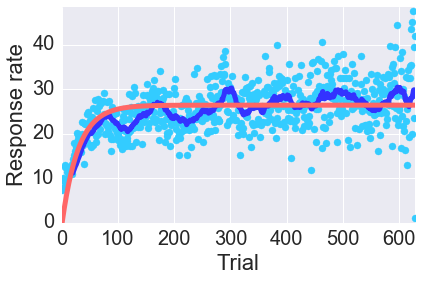

In [17]:
fig, ax = show_fit(rescorla_wagner, θhat_mean, 
                   df_mean_responserate["trial"], df_mean_responserate["mean"]);

ax.set_xlabel("Trial")
ax.set_ylabel("Response rate")
fig.tight_layout()

### 2.2.1 Fitting the individual rat

Fitting the individual rats, though, gives you an estimates of the parameters per rat. That is, it gives you an individualized learning rate and asymptotic response rate for each rat.

Writing the code as tiny modules above gives us generality. Fitting the individuals is now a simple pandas groupby away.

In [18]:
θhat_individual = (df_response_rate.groupby("subject")
                                   .rpm
                                   .apply(fit, rescorla_wagner, θ_bounds)
                                   .apply(pd.Series)
                                   .rename(columns={0:"α", 1:"A"})
                                   .reset_index()
                   )

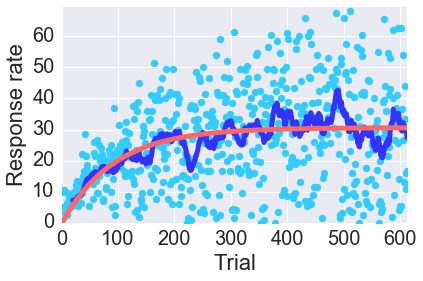

In [19]:
def show_rw_individuals(subject):
    idx = df_response_rate.subject == subject
    xdata = df_response_rate[idx].trial
    ydata = df_response_rate[idx].rpm

    θ = θhat_individual.ix[θhat_individual.subject==subject, ["α", "A"]].as_matrix()

    fig, ax = show_fit(rescorla_wagner, *θ, xdata, ydata);

    ax.set_xlabel("Trial")
    ax.set_ylabel("Response rate")
    fig.tight_layout()

show_rw_individuals(433)
#list(map(show_rw_individuals, θhat_individual.subject.unique()))

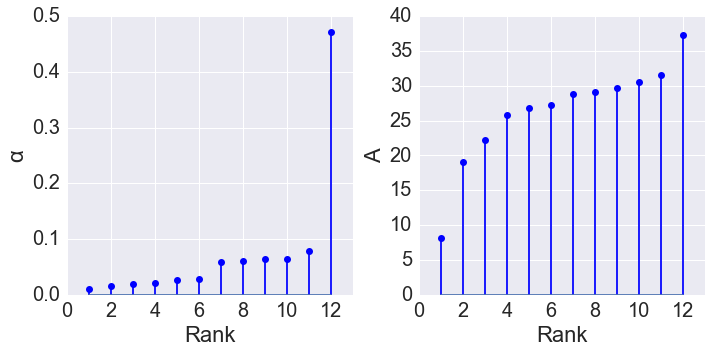

In [20]:
def show_paramter(θ, parameter, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
        
    θ_i = θ[parameter].sort_values()        
    ax.stem(range(1, 1+θ_i.size), θ_i, linefmt='b-', markerfmt='bo', basefmt='')
    
    ax.set_xlim((0, 1+θ_i.size))
    ax.set_xlabel("Rank", fontsize=22)
    ax.set_ylabel(parameter, fontsize=22)
    ax.tick_params(labelsize=20)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
show_paramter(θhat_individual, "α", ax[0])
show_paramter(θhat_individual, "A", ax[1])
fig.tight_layout()

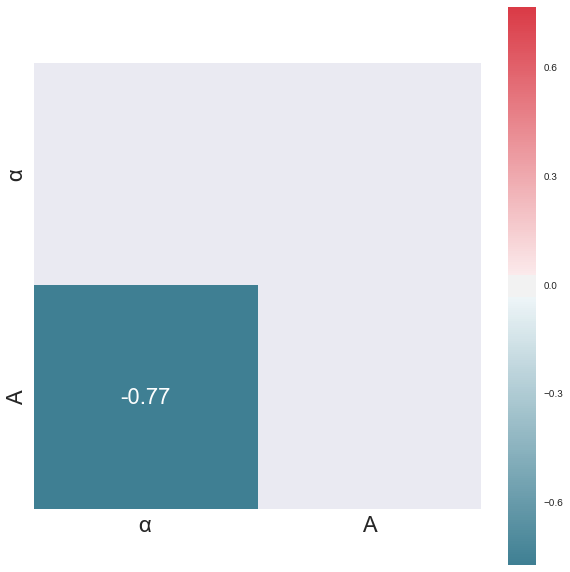

In [21]:
def corrplot(θ):
    fig, ax = plt.subplots(figsize=(10,10))
        
    corr = θ.corr()

    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    ax = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
                     annot=True, annot_kws={"size":22}, square=True)
    ax.tick_params(labelsize=22)
    
corrplot(θhat_individual[["α", "A"]])

## 3.0 Fitting Modular Theory to the learning curves

Modular theory is a process model whose input is a procedure and whose output are the times of the events. Because of this, it has many parameters that are important along the way (e.g., the parameters that generate individual responses). But many of these parameters are not important for fitting averaged data.

The explicit solution to the learning curve is

$$R(n) = A \cdot w(n) + R_0$$

where $w(n)$ is the strength memory on trial n. Notice that it looks almost identical to the Rescorla Wagner model at this pint, except for an additive operant rate $R_0$.

The value of $w(n)$ depends on the relationship between the learning rate during reinforcement and the learning rate during non-reinforcement. Each of these two are simply continuous-time Rescorla-Wagner equations with learning rates $\beta_r$ for reinforcement and $\beta_e$ for non-reinforcement. The explicit solution over trials is

$$w(n) = \beta + (w_0 - \beta)(1 - \beta_rd - \beta_eT)^n$$

where $$\beta = \frac{\beta_rd}{\beta_rd + \beta_eT}$$

that is, $\beta$ is the proportional increase in strength at the end of the trial how much reinforcement was given ($\beta_rd$) and how much non-reinforcement ($\beta_eT$).

In [22]:
def mt_learningcurve(ydata, βr, βe, R0, A):
    d, T = 1, interval # set wayy above!
    w0 = 0
    w = βr*d / (βr*d + βe*T)
    
    ntrials = ydata.size
    W = np.zeros(ntrials)
    # loop over trials.
    for n in range(1, ntrials):
        W[n] = w + (w0-w)*((1 - βr*d - βe*T)**n)
    return A*W + R0

Now that we went through all the trouble above to make the code general, all we need to do is specify the bounds on the parameters of the model, and then call the fit function

In [23]:
θ_bounds = [(0, 0, 0, 0), (.2, .2, 50, 300)]
θ_bounds = list(map(np.array, θ_bounds))

θhat_mean = fit(df_mean_responserate["mean"], mt_learningcurve, θ_bounds)

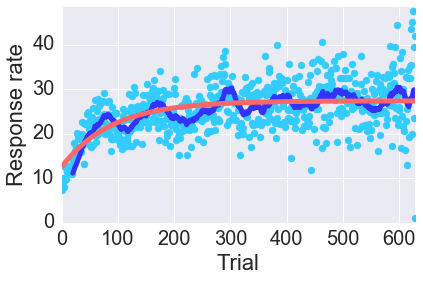

In [24]:
fig, ax = show_fit(mt_learningcurve, θhat_mean, 
                   df_mean_responserate["trial"], df_mean_responserate["mean"]);

ax.set_xlabel("Trial")
ax.set_ylabel("Response rate")
fig.tight_layout()

In [25]:
θhat_individual = (df_response_rate.groupby("subject")
                                   .rpm
                                   .apply(fit, mt_learningcurve, θ_bounds)
                                   .apply(pd.Series)
                                   .rename(columns={0:"βr", 1:"βe", 2:"R0", 3:"A"})
                                   .reset_index()
                   )

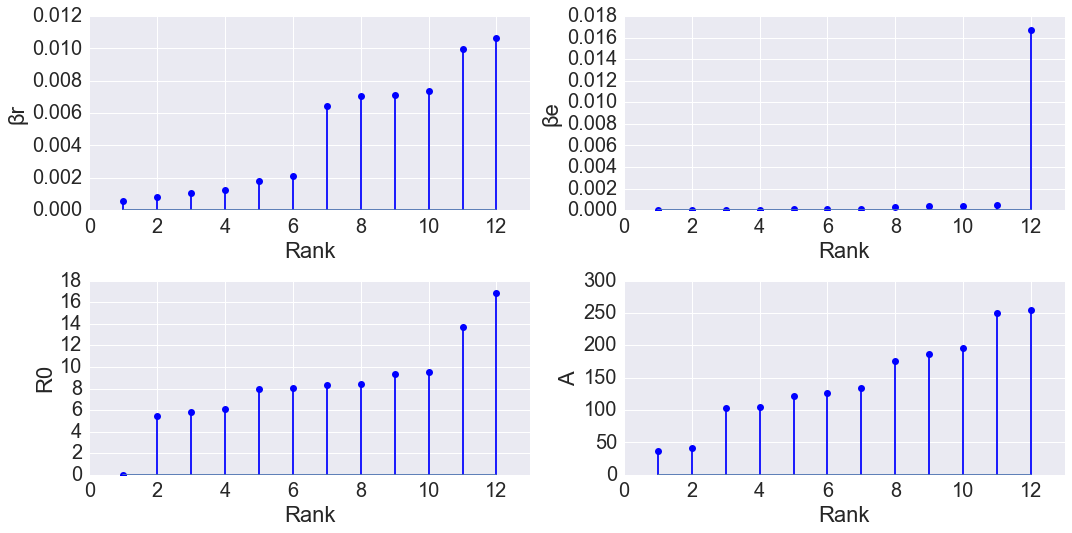

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 7.5))
show_paramter(θhat_individual, "βr", ax[0,0])
show_paramter(θhat_individual, "βe", ax[0,1])
show_paramter(θhat_individual, "R0", ax[1,0])
show_paramter(θhat_individual, "A", ax[1,1])
fig.tight_layout()

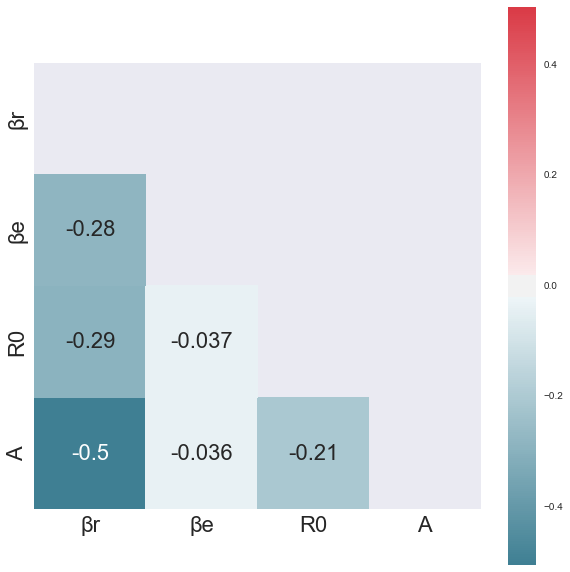

In [27]:
corrplot(θhat_individual[["βr", "βe", "R0", "A"]])

## 4.0 Fitting Modular Theory to the response gradient

### 4.1 Obtaining the response gradient

The response gradient is the moment-by-moment estimate of the response rate in a cycle. Most often, it is estimated in 1 second time bins, although any resolution can be used.

In [28]:
def response_gradient(t, n):
    """Return the response gradient"""
    counts = np.histogram(t, range=(0, int(t.max())), bins=int(t.max()))[0]
    return 60*(counts/n)

def pd_response_gradient(df):
    """Groupby wrapper for response_gradient
        takes in a data frame, and calls response_gradient
        while correctly handling the number of trials
    """
    return response_gradient(df.time, 1+(df.trial.max()-df.iloc[0].trial))

We'll compute the response gradient over the pooled response times from the last 10 sessions of the acquisition phase.

In [29]:
idx = (data.session >= data.session.max() - 10) & (data.event == 8)
df_gradient = (data[idx].groupby("subject")
                        .apply(pd_response_gradient)            # get the response gradient for each rat
                        .apply(pd.Series)                       # auto generate the bins
                        .stack()                                # which are then used as indices
                        .pipe(pd.DataFrame)                     # of the dataframe
                        .reset_index()
                        .rename(columns={"level_1": "bins", 0:"rpm"})
               )

# Average over rats
df_mean_gradient = (df_gradient.groupby("bins")
                               .rpm
                               .mean()
                               .pipe(pd.DataFrame)
                               .reset_index()
                    )

### 4.2 Fitting the response gradient with modular theory

Modular theory's explicit solution to the response gradient is given by the operant rate ($r_0$), the ($A$)symptotic rate, and the summary statistics of the start time distribution, $f(b)$, which for simplicity is assumed to be a normal distribution.

Given this, the explicit solution to modular theory is

$$\begin{align*} 
R(t) &= A\int_{m_n(t)}^{\infty} f(b)db + R_0 \\ 
     &= A \cdot \Phi(t; \mu, \sigma) + R_0
\end{align*}$$

where $\Phi(\cdot)$ is the cumulative normal distribution function

In [30]:
def mt_gradient(ydata, r, A, μ, σ):
    x = np.arange(ydata.size)
    return r + A*norm.cdf(x, μ, σ)

#### 4.2.1 Fitting the average response gradient

And now we can just use the same functions as before...

In [37]:
θ_bounds = [(0, 0, 0, 0), (100, 300, 120, 120)]
θ_bounds = list(map(np.array, θ_bounds))

θhat_mean = fit(df_mean_gradient["rpm"], mt_gradient, θ_bounds)

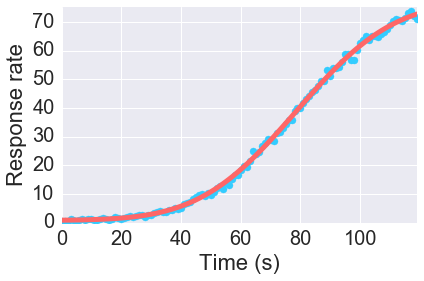

In [38]:
fig, ax = show_fit(mt_gradient, θhat_mean, 
                   df_mean_gradient["bins"], df_mean_gradient["rpm"],
                   show_smooth=False);

ax.set_xlabel("Time (s)")
ax.set_ylabel("Response rate")
fig.tight_layout()

#### 4.2.2 Fitting the individual rats

In [52]:
θhat_individual = (df_gradient.groupby("subject")
                              .rpm
                              .apply(fit, mt_gradient, θ_bounds)
                              .apply(pd.Series)
                              .rename(columns={0:"r", 1:"A", 2:"μ", 3:"σ"})
                              .reset_index()
                   )

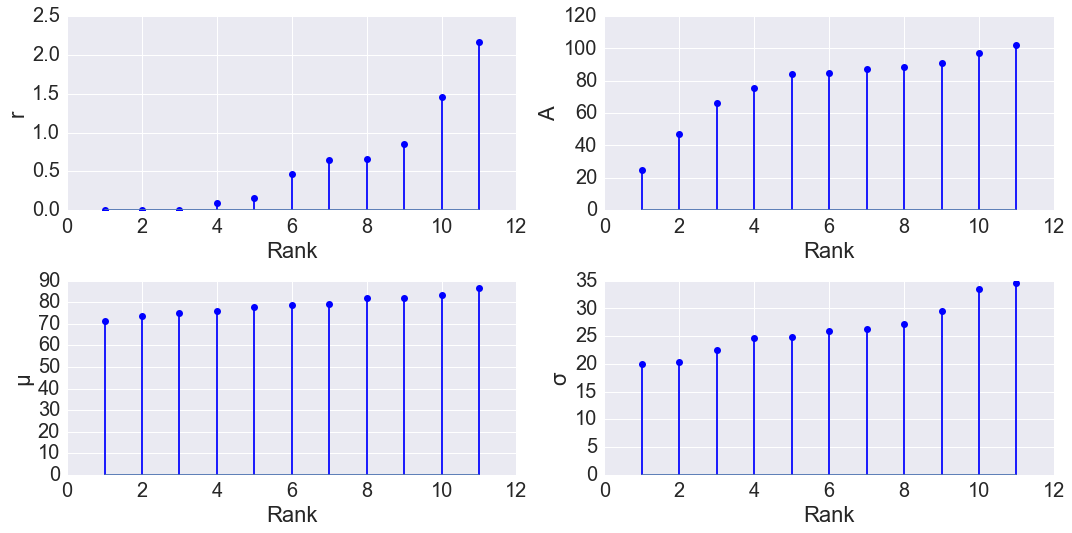

In [53]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 7.5))
show_paramter(θhat_individual, "r", ax[0,0])
show_paramter(θhat_individual, "A", ax[0,1])
show_paramter(θhat_individual, "μ", ax[1,0])
show_paramter(θhat_individual, "σ", ax[1,1])
fig.tight_layout()

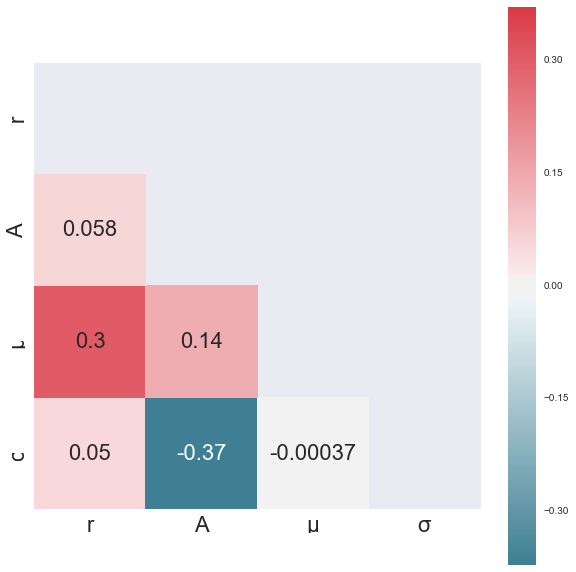

In [54]:
corrplot(θhat_individual[["r", "A", "μ", "σ"]])

[None, None, None, None, None, None, None, None, None, None, None]

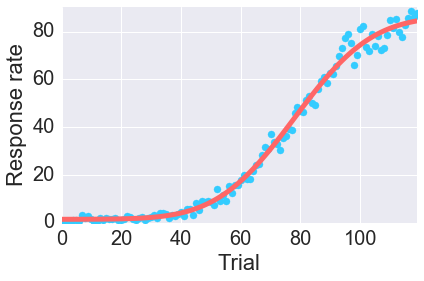

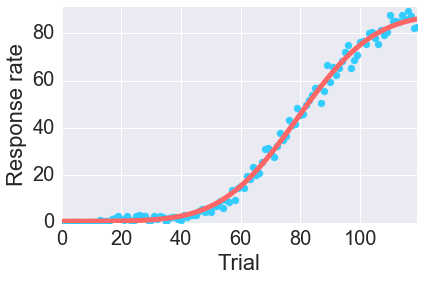

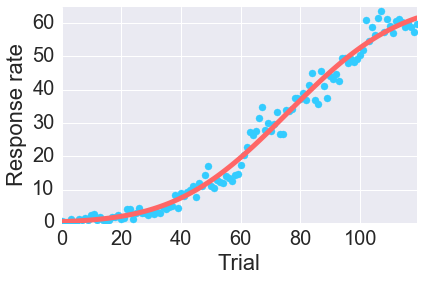

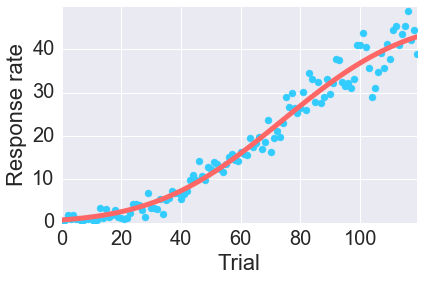

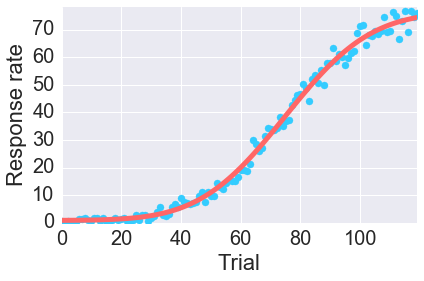

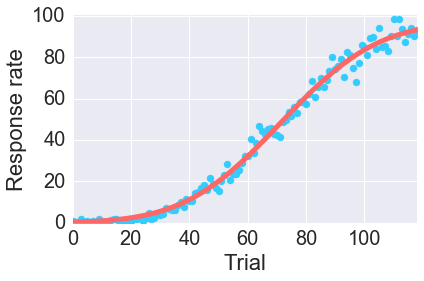

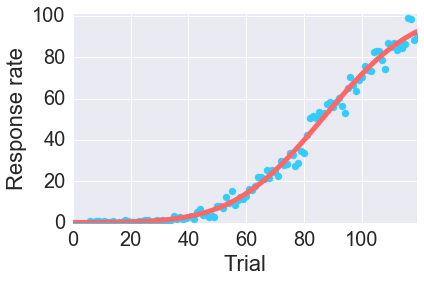

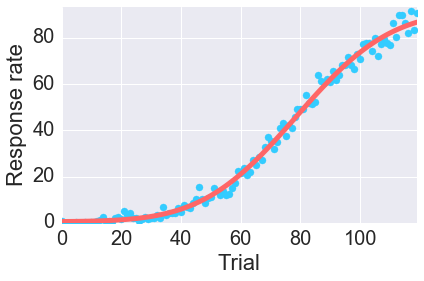

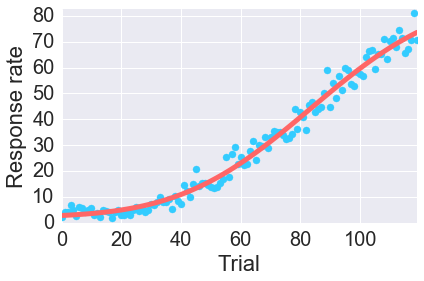

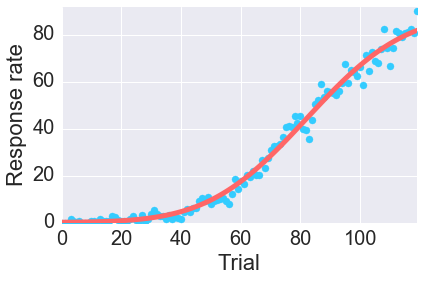

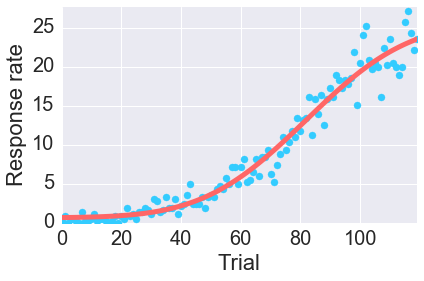

In [55]:
def show_mt_gradient_individuals(subject):
    idx = df_gradient.subject == subject
    xdata = df_gradient[idx].bins
    ydata = df_gradient[idx].rpm

    θ = θhat_individual.ix[θhat_individual.subject==subject, ["r", "A", "μ", "σ"]].as_matrix()

    fig, ax = show_fit(mt_gradient, *θ, xdata, ydata, show_smooth=False);

    ax.set_xlabel("Trial")
    ax.set_ylabel("Response rate")
    fig.tight_layout()

#show_mt_gradient_individuals(433)
list(map(show_mt_gradient_individuals, θhat_individual.subject.unique()))